In [167]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../data/raw_data.csv')

df.head()

,birads,age,mass_shape,mass_margin,mass_density,cancer
0,5,67,3,5,3,1
1,4,43,1,1,?,1
2,5,58,4,5,3,1
3,4,28,1,1,3,0
4,5,74,1,5,?,1


Null values


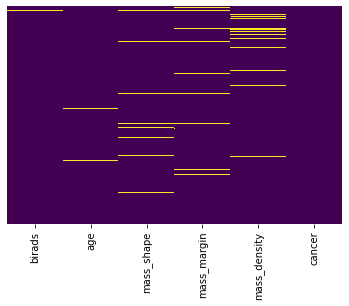

In [168]:
# Replace non numeric values for nan
df = df.apply(pd.to_numeric, errors='coerce')

print("Null values")
sns.heatmap(df.isnull(), yticklabels=False,cbar=False,cmap='viridis')


Null and misintroduced values


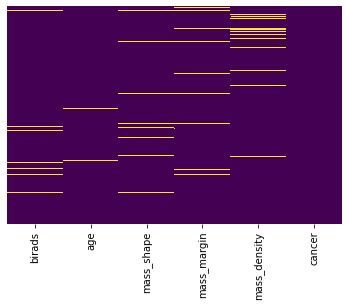

In [169]:
# Replace misintroduced values for nan (or drop them if they 
# are in the majority class)
for index, row in df.iterrows():
    for c in df.columns:
        if (c == 'birads' and (row[c] < 1 or row[c] > 5)) or \
           (c == 'age' and (row[c] < 8 or row[c] > 110)) or \
           (c == 'mass_shape' and (row[c] < 1 or row[c] > 4)) or \
           (c == 'mass_margin' and (row[c] < 1 or row[c] > 5)) or \
           (c == 'mass_density' and (row[c] < 1 or row[c] > 4)):
            df.loc[index, c] = np.nan 

print("Null and misintroduced values")
sns.heatmap(df.isnull(), yticklabels=False,cbar=False,cmap='viridis')

In [170]:
# Now we will drop rows with null values that are in the majority class
# Killing 2 birds with one stone here, since we'll have less
# values to impute and we can contribute to balance the dataset

majority_class = df['cancer'].value_counts().index[0]
excess =  df['cancer'].value_counts()[0] - df['cancer'].value_counts()[1]
print(f"There are more {excess} records in class {majority_class}")
aux = df[df.isnull().any(axis=1)]
excess_or_max = min(excess, aux[aux['cancer'] == majority_class].shape[0])
indices = aux[aux['cancer'] == majority_class].sample(excess_or_max).index 
print(f"removing {excess_or_max} indices")
print(indices)
df.drop(indices, axis=0, inplace=True)

There are more 71 records in class 0
removing 71 indices
Int64Index([ 83, 107,  88,  94, 262, 208, 371,  22, 339, 144, 133,   5, 460,
            359, 784, 574, 665,   6, 128,  35, 105,  52, 372,  43,  47,  58,
            103,  26, 142, 723, 541, 209, 116, 893, 121, 218, 100, 459, 298,
             97, 476, 691, 277, 104, 127,  48, 421, 581, 305, 745, 126, 627,
             55, 387, 187,  96, 707, 661, 163,  63,  65, 389, 394, 113, 171,
            158,  53,  85,   7,  12, 255],
           dtype='int64')


In [171]:
# Before we split the data, we have to scale it so that
# There isn't a different value interval in train and test datasets
# Since we are going to one-hot encode categorical data,
# we only need to normalize one column (age)

df['age'] -= df['age'].min()
df['age'] /= df['age'].max()

# We will separate the train/test before dealing with nul values
# Because we don't want 'synthetic' values in the test dataset
test_indices = df[df['cancer']==1].dropna().sample(40).index
test_indices = np.concatenate([test_indices, df[df['cancer']== 0].dropna().sample(40).index])
test = df.filter(test_indices, axis=0)
train = df.drop(test_indices, axis=0)

print("Test dataset:")
print(test['cancer'].value_counts())
print("Train dataset:")
print(train['cancer'].value_counts())

Test dataset:
1    40
0    40
Name: cancer, dtype: int64
Train dataset:
1    405
0    405
Name: cancer, dtype: int64


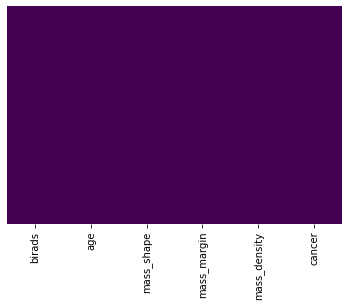

In [172]:
# Let's make sure there are no null values in the test dataset
sns.heatmap(test.isnull(), yticklabels=False,cbar=False,cmap='viridis')

,birads,age,mass_shape,mass_margin,mass_density,cancer
0,5.0,0.628205,3.0,5.0,3.0,1.0
1,4.0,0.320513,1.0,1.0,3.0,1.0
2,4.0,0.128205,1.0,1.0,3.0,0.0
3,5.0,0.717949,1.0,5.0,3.0,1.0
4,5.0,0.500000,1.0,5.0,3.0,1.0


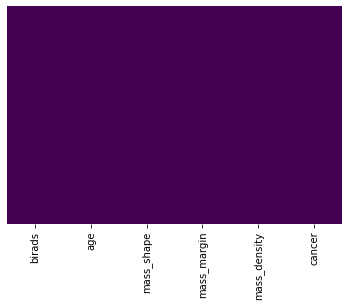

In [173]:
from sklearn.impute import KNNImputer

# We will use KNearestNeighbours to impute the missing values in our train dataset
imputer = KNNImputer(n_neighbors=500, weights="uniform")
train = pd.DataFrame(imputer.fit_transform(train.values), columns = train.columns)

# Round impuited categorical values 
# (Needed cause we will one hot encode them)
for c in ['mass_shape', 'mass_margin', 'mass_density']:
    train[c] = train[c].round(0)

sns.heatmap(train.isnull(), yticklabels=False,cbar=False,cmap='viridis')

train.head()

In [174]:
# Now that we have dealt with the null and misintroduced values,
# we can drop the BI-RADS column since we won't be using it
# (even though it was useful to impute missing data)
train.drop('birads', axis=1, inplace=True)
test.drop('birads', axis=1, inplace=True)

# Data is already balanced because of the rows we discarded when
# we searched for misintroduced values


train.head()

,age,mass_shape,mass_margin,mass_density,cancer
0,0.628205,3.0,5.0,3.0,1.0
1,0.320513,1.0,1.0,3.0,1.0
2,0.128205,1.0,1.0,3.0,0.0
3,0.717949,1.0,5.0,3.0,1.0
4,0.500000,1.0,5.0,3.0,1.0


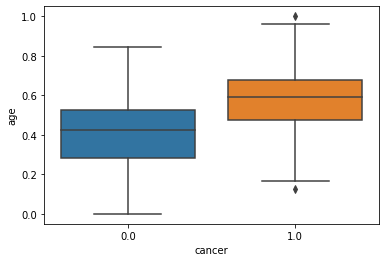

In [175]:
# Now let's take a closer at each feature individualy to see if
# there's anything else we should deal with
sns.boxplot(x='cancer', y='age', data=train)

As we could have guessed, patients that effectively have cancer tend to be older.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f056570ff60>,
      dtype=object)

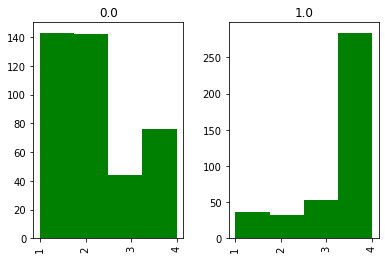

In [176]:
train['mass_shape'].hist(train['cancer'], color='green',bins=4)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f05655e7e80>,
      dtype=object)

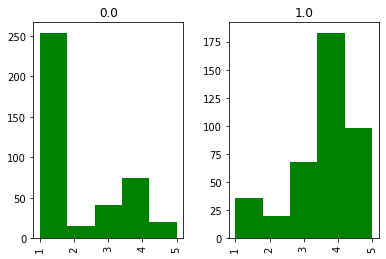

In [177]:
train['mass_margin'].hist(train['cancer'], color='green',bins=5)

Both mass shape and mass margin are features that seem to show a completely different distribution in cancer vs no-cancer cases.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f05654e8978>,
      dtype=object)

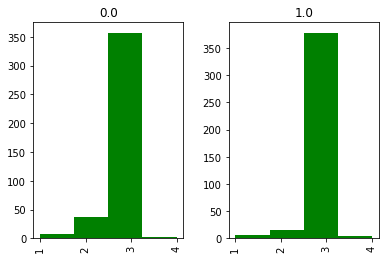

In [178]:
train['mass_density'].hist(train['cancer'], color='green',bins=4)

Probably mass density isn't going to be much of a strong factor in the prediction.


In [179]:
for c in ['mass_shape', 'mass_margin', 'mass_density']:
    for v in pd.concat([train, test], axis= 0)[c].unique():
        train[f"{c}_{v}"] =  [1 if x == v else 0 for x in train[c]]
        test[f"{c}_{v}"] =  [1 if x == v else 0 for x in test[c]]
    train.drop(c, axis=1, inplace=True)
    test.drop(c, axis=1, inplace=True)


In [180]:
# Everything seems to be fine
# Finally, we just write both dataset into csv files 
train.to_csv("../data/train.csv", index=False)
test.to_csv("../data/test.csv", index=False)